## Doing Bayesian Linear Regression the Hackers way

**Goal:** Show that bayesian linear regression is not magic.

**Usage:** 

**Dataset:** Artificial Data

**Content:**

In [1]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow==2.0.0-alpha0  
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-alpha0  running in colab?:  False


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions
print("TFB Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFB Version 0.7.0-dev20190511
TF  Version 2.0.0-alpha0


In [3]:
plt.style.use('default') # macht den hintergrund weg 
plt.rcParams.update({'font.size': 15}) #Macht grosse axen

In [4]:
bmin=amin=-3;bmax=amax=3;xmin = -10;xmax = +10;ymin=-30;ymax=30;
nbins_c=30

In [5]:
np.random.seed(2)
num = 4
#x = np.random.normal(0,1,(num,1)) 
x = np.linspace(-2,2,num=num).reshape((num,1))
y = 2 * x[:,0] - 1 + 1.*np.random.normal(0,3,num) 

from sklearn import linear_model
regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(x,y)
# The coefficients
a_ml = regr.coef_
b_ml = regr.intercept_
print('Coefficients: \n', a_ml)
print('Coefficients: \n', b_ml)

Coefficients: 
 [2.92051026]
Coefficients: 
 -1.726712471421449


### Creation of the data set

x  (4, 1)    (4,)


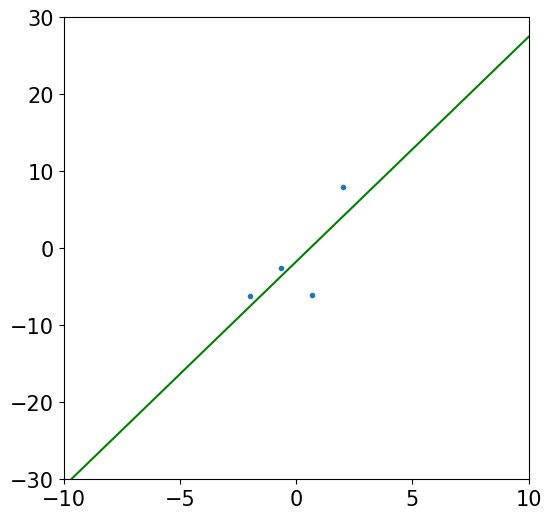

In [6]:
fig = plt.figure(figsize=(6,6))
def createData(save=True):
    #num = 10 
    plt.scatter(x,y, marker='.')
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.plot([xmin, xmax], [a_ml*xmin+b_ml, a_ml*xmax+b_ml], color='g', alpha = 1)
    print("x ", x.shape, "  ", y.shape)
    if save:
        d = np.transpose(np.vstack((x[:,0],y)))
        np.savetxt('nb_ch06_bayes{}.csv'.format(num), d, delimiter=',', header='x,y',comments="",fmt='%.4e');     
    return (x,y)
x,y = createData()

Calculation of the predictive distribution $p(y|x,a,b)$ for a bunch of values x, and y given a fixed set of parameters.

In [7]:
def pre_distribution(a,b):
    """
        Return the predictive distribution for a, b
    """
    canvas0 = np.zeros((nbins_c, nbins_c), dtype=np.float32) #The complete img
    for j,x_ in enumerate(np.linspace(xmin, xmax, nbins_c)):
        py = tfd.Normal(loc=a*x_+b,scale=3)
        for i,y_ in enumerate(np.linspace(ymin, ymax, nbins_c)):
                canvas0[nbins_c-i-1,j] = py.prob(y_)
    # This part is a bit tricky. The sum over y for a fixed a should be 1. 
    # However, IMHO due to (more than finite) bin width this is not the case
    # We renormalize
    return canvas0 / np.sum(canvas0,axis=0)

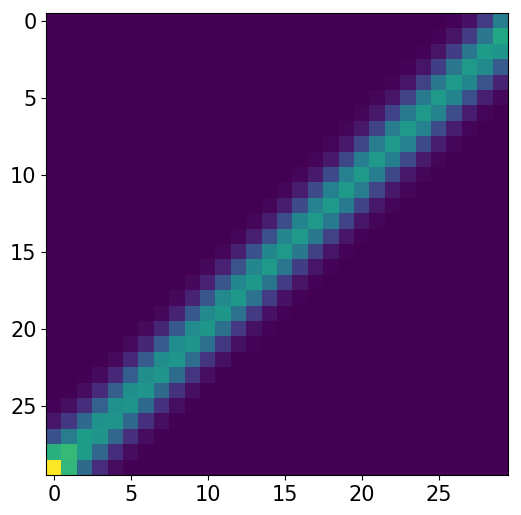

In [8]:
fig = plt.figure(figsize=(6,6))
pxy_ml = pre_distribution(a_ml, b_ml)
plt.imshow(pxy_ml)

In [9]:
np.sum(pxy_ml,axis=0) #

array([1.        , 1.        , 1.        , 1.0000001 , 1.        ,
       1.0000001 , 1.        , 1.        , 1.        , 1.        ,
       0.99999994, 1.0000001 , 1.        , 1.        , 1.        ,
       1.        , 1.0000001 , 0.99999994, 1.        , 0.99999994,
       1.0000001 , 1.        , 1.0000001 , 1.0000001 , 1.        ,
       1.        , 1.        , 0.99999994, 0.99999994, 1.0000001 ],
      dtype=float32)

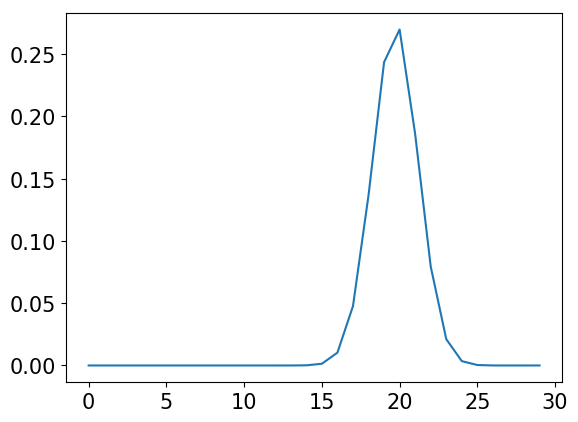

In [10]:
plt.plot(pxy_ml[:,10])

* Don't put all egg in one basket
* While it's best to use the line with the highest prob. why not also take other solutions into account?
* OK maybe not with full weight
* The more prob. they are the more we take them into account
* Idea: Sample `a` and `b` randomly (uniform). Always take the parameters with the hightest probabiliy.
    * If less then highest only take them in a certain fraction. Choose this proportional to prob.

In [11]:
ytensor = y.reshape([len(y),1])
def unnormalized_likehihood(w):
    y_prob = tfd.Independent(tfd.Normal(loc=x*w[0]+w[1], scale=1.0), reinterpreted_batch_ndims=1)
    return (tf.reduce_sum(tf.reduce_sum(y_prob.log_prob(ytensor))))

In [12]:
nbins = 10
bmin=-5;bmax=2
amin=1;amax=6
ai, bi = np.mgrid[amin:amax:nbins*1j, bmin:bmax:nbins*1j] #wtf is j?
ws = np.vstack([ai.flatten(), bi.flatten()])
unpost = np.zeros((nbins*nbins))
for i in range((nbins*nbins)):
    unpost[i] = unnormalized_likehihood(tf.Variable([[ws[0,i]],[ws[1,i]]],dtype=tf.float32))/num
unpost = np.exp(unpost.reshape(ai.shape))
post = unpost / np.sum(unpost) #<-- We normalize

Text(0.5, 1.0, 'Likelihood')

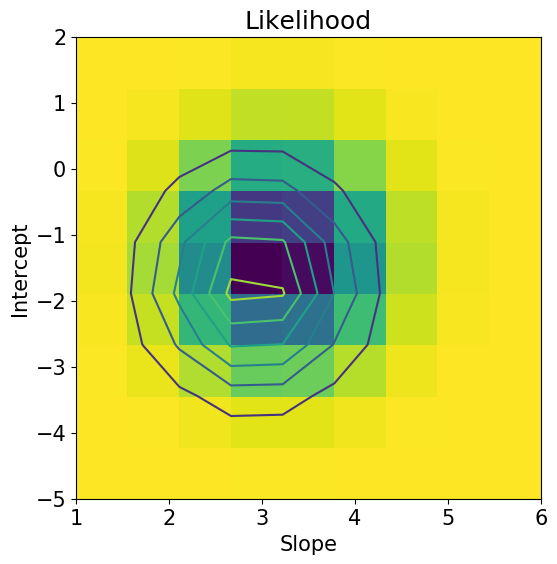

In [13]:
fig = plt.figure(figsize=(6,6))
plt.pcolormesh(ai, bi, -unpost, shading='none',cmap="viridis")
plt.contour(ai, bi, post)
plt.xlabel('Slope')
plt.ylabel('Intercept')
plt.title('Likelihood')

In [14]:
def toBin(a, amin, amax):
    a = np.clip(a, amin, amax)
    return int(0.99999*(a - amin)/(amax-amin) * nbins)

def getProb(a,b):
    return post[toBin(a,amin,amax),toBin(b,bmin,bmax)]

Evaluation of 
$$
    p(y|x,D) = \sum_a \sum_b p(y|x,(a,b))p((a,b)|D)
$$

In [15]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
pyx = np.zeros((nbins_c, nbins_c), dtype=np.float32) #A 
for a in np.linspace(amin, amax, nbins): #B
    for b in np.linspace(bmin, bmax, nbins):
        p = getProb(a,b) #C
        pyx += pre_distribution(a,b) * getProb(a,b) 
        if (b == bmin):
            print(p)
#A Start with a blank canvas
#B Loop over "all" parameters a 
#C Get the probability for the parameters a and b, given the data

8.027548077762843e-06
6.10042119533526e-05
0.00023348958386415635
0.00045009557389333045
0.00043699043265749485
0.00021368296395093622
5.262559225181563e-05
6.527607748484998e-06
4.0779421216020713e-07
1.2830951091899081e-08


Text(0, 0.5, 'y')

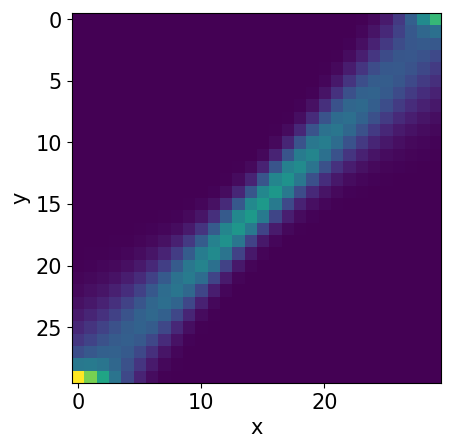

In [16]:
plt.imshow(pyx)
plt.xlabel('x')
plt.ylabel('y')

In [17]:
np.sum(pyx, axis=0) 

array([1.        , 1.        , 1.        , 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 1.        , 0.99999994, 1.        ,
       0.9999998 , 0.99999994, 0.9999999 , 0.99999994, 0.9999998 ,
       0.99999994, 0.9999999 , 0.99999994, 0.99999994, 0.99999994,
       0.9999999 , 1.        , 0.99999994, 0.99999994, 1.0000001 ,
       0.9999998 , 0.99999994, 0.9999998 , 0.9999999 , 0.99999994],
      dtype=float32)

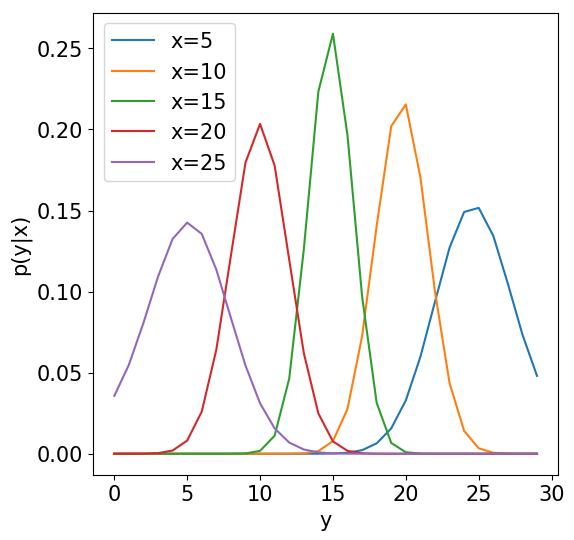

In [18]:
fig = plt.figure(figsize=(6,6))
plt.plot(pyx[:,(5,10,15,20,25)]) 
plt.xlabel('y')
plt.ylabel('p(y|x)')
plt.legend(['x=5','x=10','x=15','x=20','x=25'])

## Using Tensor Power TODO